### Text preprocessing for Topic Modeling

#### Setup for Google Colab

In [1]:
from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/MyDrive/ChiLit_Topic_Modeling
import os
os.getcwd()
!pip install bibtexparser
!pip install requests
!pip install stanza

Mounted at /content/drive
/content/drive/MyDrive/ChiLit_Topic_Modeling
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.6/55.6 kB 4.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for bibtexparser: filename=bibtexparser-1.4.3-py3-none-any.whl size=43549 sha256=51f8f8e8f1efc84cc5d397388fc27e194fdf266c397db1e5e6d10616d5961f2d
  Stored in directory: /root/.cache/pip/wheels/16/fb/76/306387739cf9d53b1c39b0c8aadbbb17dc05f256756d8fd915
Successfully built bibtexparser
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 29.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 1.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 71.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 31.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 20.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [2]:
import bibtexparser
import requests
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import json
import re
import csv
import stanza
import glob

### Metadata

In [ ]:
url = 'https://raw.githubusercontent.com/mahlberg-lab/corpora/refs/heads/master/corpora.bib'
filename = 'corpora.bib'
response = requests.get(url)
if response.status_code == 200:
  bibtex_str = response.content

In [ ]:
library = bibtexparser.loads(bibtex_str)

In [ ]:
library.entries[0]

{'keywords': '{ChiLit}',
 'date': '1900',
 'urldate': '2017-09-10',
 'author': 'Anstey, F.',
 'shorttitle': 'brass',
 'url': 'https://www.gutenberg.org/ebooks/30689',
 'title': 'The Brass Bottle',
 'ENTRYTYPE': 'book',
 'ID': 'anstey_brass_1900'}

In [ ]:
df = pd.DataFrame(library.entries)

In [ ]:
df.head()

,keywords,date,urldate,author,shorttitle,url,title,ENTRYTYPE,ID,editor,publisher,number,series,location
0,{ChiLit},1900,2017-09-10,"Anstey, F.",brass,https://www.gutenberg.org/ebooks/30689,The Brass Bottle,book,anstey_brass_1900,NaN,NaN,NaN,NaN,NaN
1,{ChiLit},1897,2017-09-10,"Crockett, S. R.",toadylion,https://www.gutenberg.org/ebooks/39340,The Surprising Adventures of Sir Toady Lion wi...,book,crockett_surprising_1897,NaN,NaN,NaN,NaN,NaN
2,{ChiLit},1910,2017-09-10,"Mare, W. De la",mulgars,https://www.gutenberg.org/ebooks/32620,The Three Mulla-mulgars,book,mare_three_1910,NaN,NaN,NaN,NaN,NaN
3,{ChiLit},1869,2017-09-10,"Ewing, J. H. G.",overtheway,https://www.gutenberg.org/ebooks/17772,Mrs. Overtheway's Remembrances,book,ewing_mrs._1869,NaN,NaN,NaN,NaN,NaN
4,{ChiLit},1883,2017-09-10,"Ewing, J. H. G.",jackanapes,https://www.gutenberg.org/ebooks/20351,Jackanapes,book,ewing_jackanapes_1883,NaN,NaN,NaN,NaN,NaN


In [ ]:
df_chilit = df[df['keywords'] == '{ChiLit}'][['author','title','date','shorttitle']]

In [ ]:
len(df_chilit)

71

In [ ]:
df_chilit.to_csv("ChiLit_metadata.csv", encoding="utf-8", index=False)

In [ ]:
print(df_chilit['date'].min())
print(df_chilit['date'].max())

1826
1911


In [ ]:
df_chilit['decade'] = [ int(np.floor(int(year)/10) * 10) for year in np.array(df_chilit["date"])]

<Axes: xlabel='decade'>

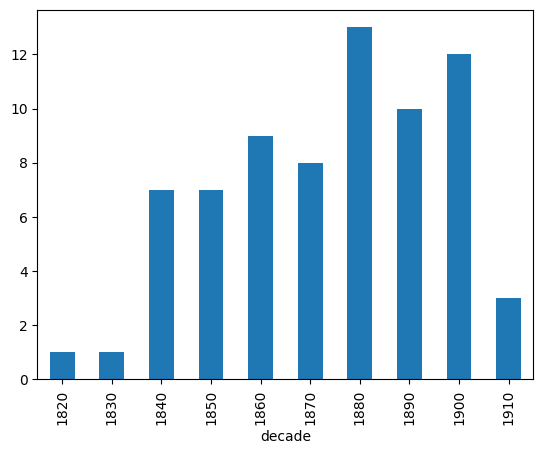

In [ ]:
df_chilit.groupby(['decade'])['title'].count().plot(kind='bar')

### Split into chapters

In [ ]:
def download_clic_json(url, output_filename):
    try:
        response = requests.get(url)
        response.raise_for_status()  # Raise exception for HTTP errors

        # Parse JSON content
        data = response.json()

        # Save to a JSON file
        with open(output_filename, 'w', encoding='utf-8') as f:
            json.dump(data, f, indent=2, ensure_ascii=False)

        print(f"JSON data saved to '{output_filename}'.")

    except requests.exceptions.RequestException as e:
        print(f"Request failed: {e}")
    except ValueError as ve:
        print(f"Failed to parse JSON: {ve}")

In [5]:
df_chilit = pd.read_csv("ChiLit_metadata.csv", encoding = "utf-8")

In [ ]:
for index, row in df_chilit.iterrows():
    book = row['shorttitle']
    url = f"https://clic.bham.ac.uk/api/text?corpora={book}&regions=chapter.title"
    output_file = f"{os.getcwd()}/data/chapters_metadata/{book}_chapters.json"
    download_clic_json(url, output_file)

JSON data saved to '/content/drive/MyDrive/ChiLit_Topic_Modeling/data/chapters_metadata/brass_chapters.json'.


In [ ]:
for index, row in df_chilit.iterrows():

    book = row['shorttitle']
    json_file = f"./data/chapters_metadata/{book}_chapters.json"

    with open(json_file, 'r', encoding='utf-8') as f:
        data = json.load(f)

    chapter_start = [s[1] for s in data['data']]
    if len(chapter_start) == 0:
        print("Cannot split: " + book)
        chapter_start.append(0)
    chapter_start.append(len(data['content']))

    chapter_num = 1
    for start_char, end_char in zip(chapter_start, chapter_start[1:]):
        chapter_text = data['content'][start_char:end_char]
        chapter_file = f"./data/chapters/{book}_{chapter_num:03}.txt"
        with open(chapter_file, 'w', encoding='utf-8') as f:
            f.write(chapter_text)
        chapter_num +=1

Cannot split: overtheway
Cannot split: unlikely
Cannot split: rival
Cannot split: prince
Cannot split: squirrel
Cannot split: bunny
Cannot split: mice
Cannot split: rabbit
Cannot split: jemima
Cannot split: jungle
Cannot split: flopsy


Split by book specific chapter identifiers

unlikely, prince -> split at "BOOK (n)"

overtheway:
https://www.gutenberg.org/cache/epub/17772/pg17772.txt
    IDA
    MRS. MOSS
    THE SNORING GHOST
    REKA DOM

jungle
https://www.gutenberg.org/cache/epub/236/pg236.txt
    Mowgli’s Brothers
    Hunting-Song of the Seeonee Pack
    Kaa’s Hunting
    Road-Song of the Bandar-Log
    “Tiger! Tiger!”
    Mowgli’s Song
    The White Seal
    Lukannon
    “Rikki-Tikki-Tavi”
    Darzee’s Chant
    Toomai of the Elephants
    Shiv and the Grasshopper
    Her Majesty’s Servants
    Parade Song of the Camp

rival (sono 3 storie) provare divisione semantica con llm https://chatgpt.com/c/688299e8-05a0-8323-b945-7525dcf6f27e
file:///C:/Users/giovannt/Downloads/The%20Rival%20Crusoes%20(Strickland%20Agnes)%20(Z-Library).htm#THE_RIVAL_CRUSOES
    THE RIVAL CRUSOES
    ARTHUR RIDLEY
    THE FISHERMAN'S COTTAGE

squirrel, bunny, mice, rabbit, jemima, flopsy sono di Beatrice Potter, lasciare unico file

manca fiord

errore in water

In [ ]:
def split_chapters(book, chapter_list):

    text_file = f"./data/ChiLit/{book}.txt"

    with open(text_file, 'r', encoding='utf-8') as f:
        text_lines = f.readlines()

    chapters = {}
    for line, text in enumerate(text_lines):
        if text.strip() in chapter_list:
            chapter_num = chapter_list.index(text.strip()) + 1
            chapters[chapter_num] = line

    for chapter, start_line in chapters.items():
        if chapter == len(chapters):
            end_line = len(text_lines) + 1
        else:
            end_line = chapters[chapter + 1]

        chapter_text = ''.join(text_lines[start_line : end_line - 1])
        chapter_file = f"./data/chapters/{book}_{chapter:03}.txt"
        with open(chapter_file, 'w', encoding='utf-8') as f:
            f.write(chapter_text)

In [ ]:
jungle_chapters = [
  'Mowgli’s Brothers',
  'Kaa’s Hunting',
  '“Tiger! Tiger!”',
  'The White Seal',
  '“Rikki-Tikki-Tavi”',
  'Toomai of the Elephants',
  'Her Majesty’s Servants',
]

split_chapters('jungle', jungle_chapters)

In [ ]:
text_file = "./data/ChiLit/unlikely.txt"

with open(text_file, 'r', encoding='utf-8') as f:
    text = f.read()

matches = re.findall(r"^BOOK \d+\..*$", text, re.MULTILINE)
print(matches)
split_chapters('unlikely', matches)

['BOOK 1. _THE COCKATOUCAN_ _OR GREAT AUNT WILLOUGHBY_', 'BOOK 2. WHEREYOUWANTOGO. or THE BOUNCIBLE BALL.', 'BOOK 3. THE BLUE MOUNTAIN', 'BOOK 4. _THE PRINCE, TWO MICE, AND SOME KITCHEN-MAIDS_', 'BOOK 5. _MELISANDE_ _OR, LONG AND SHORT DIVISION_', 'BOOK 6. _FORTUNATUS REX & CO._', 'BOOK 7. _THE SUMS THAT CAME RIGHT_', 'BOOK 8. _THE TOWN IN THE LIBRARY IN THE TOWN IN THE LIBRARY_', 'BOOK 9. _THE PLUSH USURPER_']


In [ ]:
text_file = "./data/ChiLit/prince.txt"

with open(text_file, 'r', encoding='utf-8') as f:
    text = f.read()

matches = re.findall(r"^BOOK \d+\..*$", text, re.MULTILINE)
print(matches)

split_chapters('prince', matches)

['BOOK 1. The Happy Prince.', 'BOOK 2. The Nightingale and the Rose.', 'BOOK 3. The Selfish Giant.', 'BOOK 4. The Devoted Friend.', 'BOOK 5. The Remarkable Rocket.']


In [ ]:
overtheway_chapters = [
    'IDA.',
    'MRS. MOSS.',
    'THE SNORING GHOST.',
    'REKA DOM.'
]
split_chapters('overtheway', overtheway_chapters)

In [ ]:
rival_chapters = [
    'The Rival Crusoes',
    'ARTHUR RIDLEY;',
    'THE FISHERMAN\'S COTTAGE.'
]
split_chapters('rival', rival_chapters)

In [ ]:
from corpusanalyzer import CorpusAnalyzer
import nltk
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.corpus.reader import PlaintextCorpusReader

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


In [ ]:
data_dir = './data/'
chilit = PlaintextCorpusReader(root = data_dir + "chapters", fileids = r'.+\.txt')
# Initialize analyzer
analyzer = CorpusAnalyzer(chilit)
# Perform analysis
individual_stats, corpus_summary, df = analyzer.analyze_corpus()

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


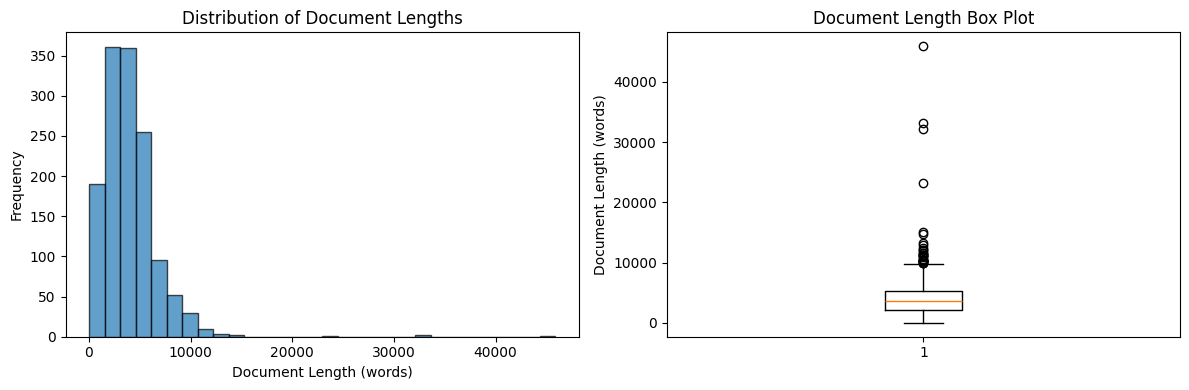

In [ ]:
# Analysis of Document Lenghts
doc_lengths, stats = analyzer.analyze_document_lengths(individual_stats)
analyzer.plot_length_distribution(doc_lengths)

In [ ]:
individual_stats_by_words = sorted(individual_stats, key=lambda d: -d['total_words'])

In [ ]:
[(file_stats['file_id'], file_stats['total_words'])for file_stats in individual_stats_by_words][0:15]

[('fiord_001.txt', 45890),
 ('rival_001.txt', 33158),
 ('overtheway_004.txt', 32175),
 ('water_007.txt', 23250),
 ('overtheway_003.txt', 15157),
 ('redclyffe_043.txt', 14830),
 ('dreamdays_007.txt', 13252),
 ('peasant_012.txt', 12958),
 ('stalky_001.txt', 12458),
 ('overtheway_002.txt', 12129),
 ('howwhy_013.txt', 12057),
 ('stalky_003.txt', 11672),
 ('wallypug_017.txt', 11543),
 ('redclyffe_005.txt', 11261),
 ('jungle_002.txt', 11247)]

#### Split chapters into paragraphs

In [ ]:
for fileid in chilit.fileids():
    file_name = f'./data/paragraphs/{fileid}'.replace(".txt", ".csv")
    #print(file_name)
    with  open(file_name, 'w', newline ='') as file:

        header = ['id','paragraph']
        writer = csv.DictWriter(file, fieldnames = header)
        writer.writeheader()

        text = chilit.raw(fileids = fileid)

        paragraphs = text.split("\n\n")
        id = 0
        if len(paragraphs) == 1:
          print("Cannot split " + fileid)

        #print(fileid, len(paragraphs))

        for paragraph in paragraphs:

            id += 1

            writer.writerow({
                  'id' : id,
                  'paragraph' : paragraph.replace("\n", " "),
              })

#### Parse paragraphs, filter content words

In [3]:
stanza.download('en')
nlp = stanza.Pipeline(
    lang='en',
    processors='tokenize,mwt,lemma,pos'
)

INFO:stanza:Downloaded file to /root/stanza_resources/resources.json
INFO:stanza:Downloading default packages for language: en (English) ...


INFO:stanza:Downloaded file to /root/stanza_resources/en/default.zip
INFO:stanza:Finished downloading models and saved to /root/stanza_resources
INFO:stanza:Checking for updates to resources.json in case models have been updated.  Note: this behavior can be turned off with download_method=None or download_method=DownloadMethod.REUSE_RESOURCES


INFO:stanza:Downloaded file to /root/stanza_resources/resources.json
INFO:stanza:Loading these models for language: en (English):
| Processor | Package           |
---------------------------------
| tokenize  | combined          |
| mwt       | combined          |
| pos       | combined_charlm   |
| lemma     | combined_nocharlm |

INFO:stanza:Using device: cuda
INFO:stanza:Loading: tokenize
INFO:stanza:Loading: mwt
INFO:stanza:Loading: pos
INFO:stanza:Loading: lemma
INFO:stanza:Done loading processors!


In [5]:
df_chilit = pd.read_csv("ChiLit_metadata.csv", encoding = "utf-8")

In [8]:
for file_path in sorted(glob.iglob(f'./data/paragraphs/*.csv')):

  with open(file_path, mode ='r', encoding='utf-8') as file_csv:

    csvFile = csv.reader(file_csv)
    next(csvFile)

    file_name = f'./data/parsed/{os.path.basename(file_path)}'
    with  open(file_name, 'w', newline ='', encoding='utf-8') as file:

        header = ['id','paragraph','tokens']
        writer = csv.DictWriter(file, fieldnames = header)
        writer.writeheader()
        for line in csvFile:

          paragraph_num = line[0]
          paragraph_text = line[1]

          doc = nlp(paragraph_text)

          tokens = ''
          for sentence in doc.sentences:
            for word in sentence.words:
              if word.upos in ['NOUN', 'VERB', 'ADJ']:
                tokens += word.lemma.lower() + ' '

          writer.writerow({
              'id' : paragraph_num,
              'paragraph' : paragraph_text,
              'tokens' : tokens
          })





#### Single csv file of all parsed paragraphs

In [10]:
extension = '.csv'
with  open('./data/ChiLit_Paragraphs.csv', 'w', newline ='', encoding = 'utf-8') as file:

    header = ['book_id', 'chapter_num', 'paragraph_num', 'paragraph_text', 'tokens']
    writer = csv.DictWriter(file, fieldnames = header)
    writer.writeheader()

    for file_path in sorted(glob.iglob(f'./data/parsed/*{extension}')):
        file_name = os.path.basename(file_path)
        file_info = file_name.replace(extension, '').split("_")
        book_id = file_info[0]
        chapter_num = int(file_info[1])

        with open(file_path, mode ='r', encoding='utf-8') as file_csv:
            csvFile = csv.reader(file_csv)
            next(csvFile)

            for lines in csvFile:

                paragraph_num = lines[0]
                paragraph_text = lines[1]
                tokens = lines[2]

                writer.writerow(
                    {
                        'book_id' : book_id,
                        'chapter_num' : chapter_num,
                        'paragraph_num' : paragraph_num,
                        'paragraph_text' : paragraph_text,
                        'tokens': tokens
                    }
                )


In [11]:
df_par = pd.read_csv('./data/ChiLit_Paragraphs.csv', encoding = 'utf-8')

In [12]:
df_par.head()

,book_id,chapter_num,paragraph_num,paragraph_text,tokens
0,alice,1,1,CHAPTER I. Down the Rabbit-Hole,hole
1,alice,1,2,Alice was beginning to get very tired of sitti...,begin get tired sit sister bank have do peep b...
2,alice,1,3,So she was considering in her own mind (as wel...,consider own mind hot day make feel sleepy stu...
3,alice,1,4,There was nothing so VERY remarkable in that; ...,be remarkable think way hear say dear dear lat...
4,alice,1,5,"In another moment down went Alice after it, ne...",moment go consider world get


In [45]:
df_par['token_count'] = df_par['tokens'].str.split().str.len()
df_par['token_count'] = df_par['token_count'].fillna(0)

In [46]:
print(df_par['token_count'].mean())
print(df_par['token_count'].std())

17.286191407282143
21.63281187876672


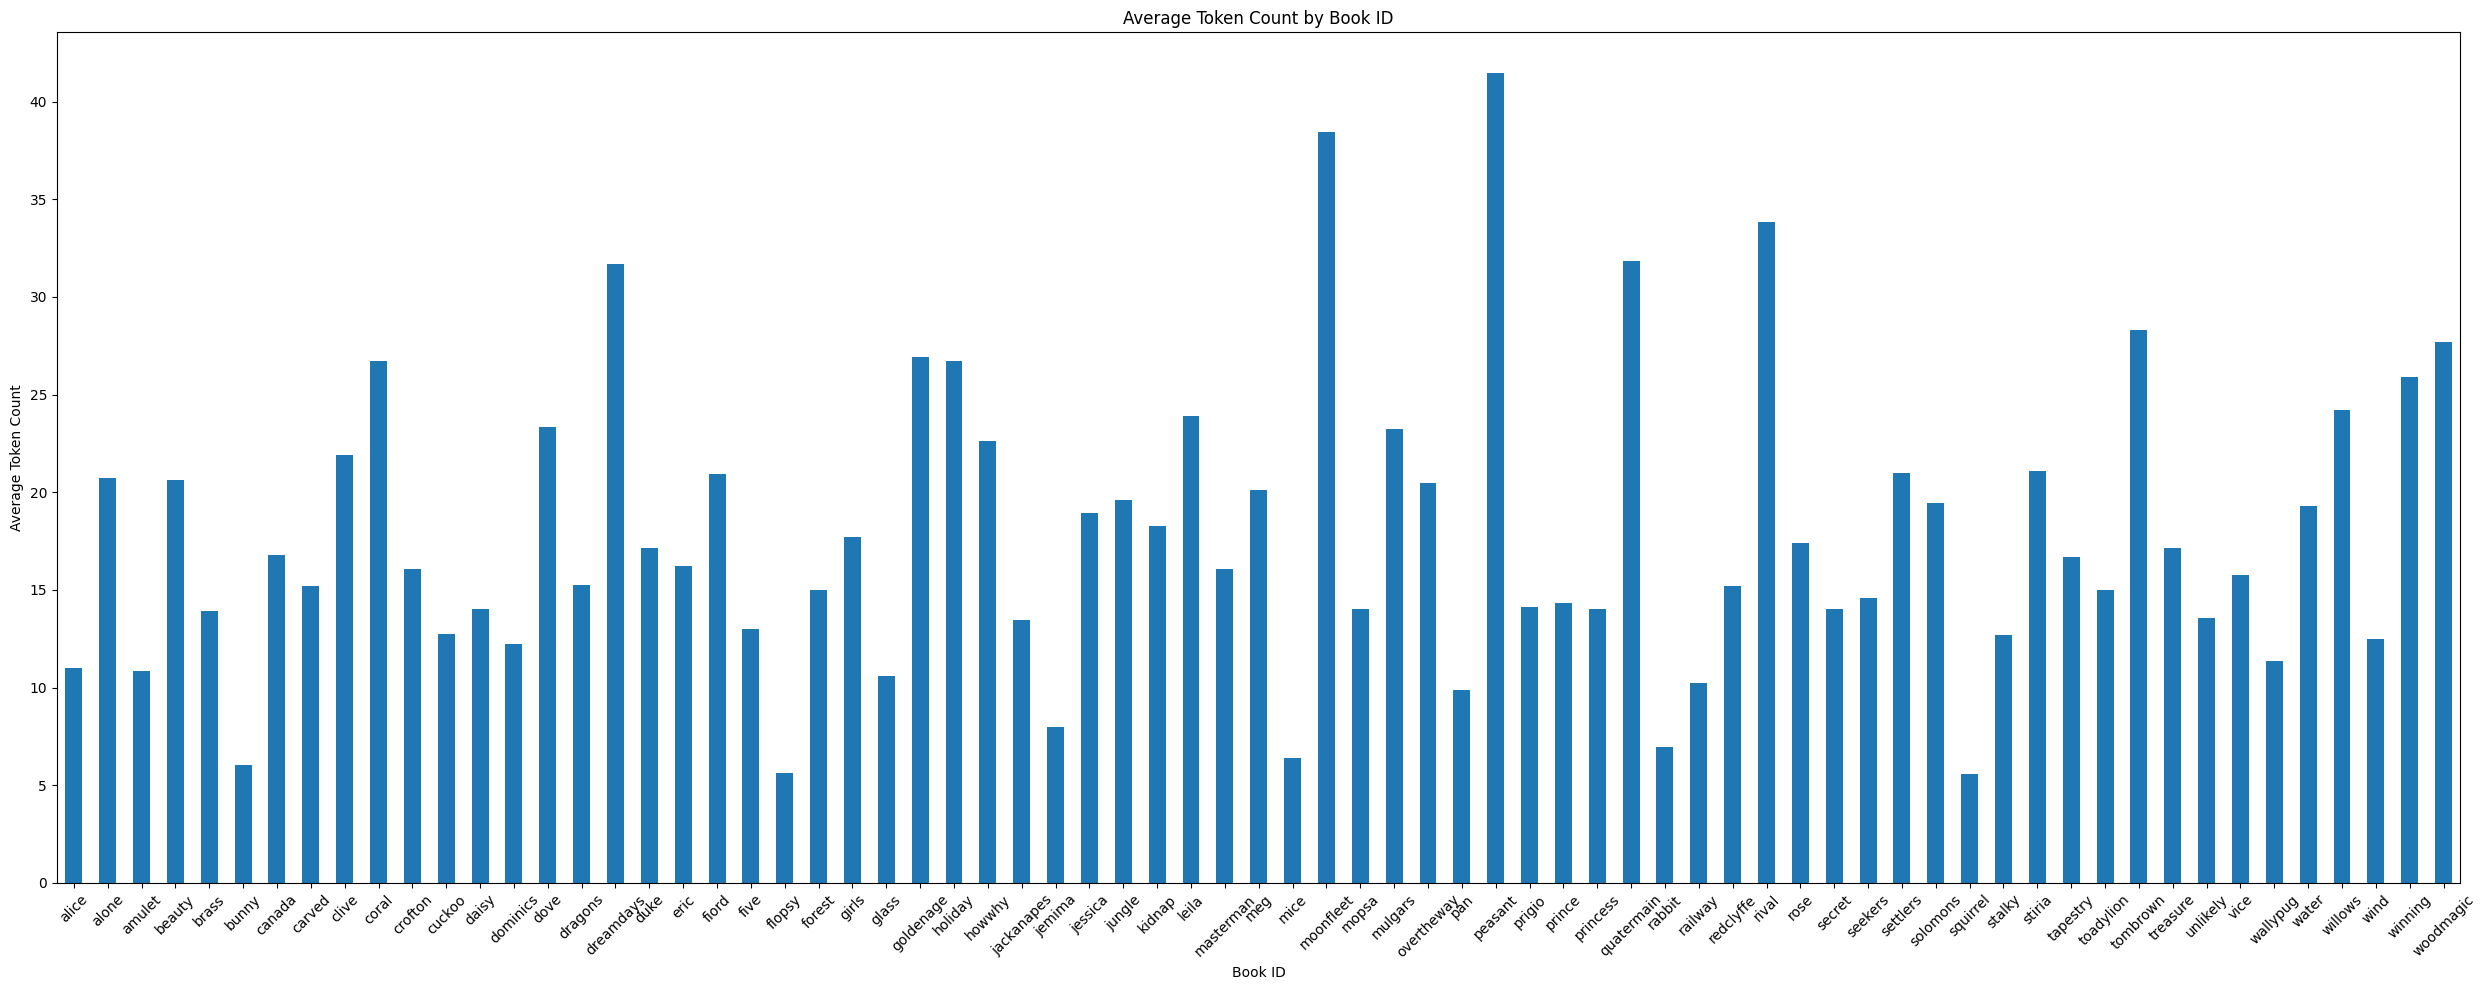

In [47]:
# Group by book_id and compute the mean token count
avg_token_count = df_par.groupby(['book_id'])['token_count'].mean()

# Plot
avg_token_count.plot(kind='bar', figsize=(25, 10))
plt.xlabel('Book ID')
plt.ylabel('Average Token Count')
plt.title('Average Token Count by Book ID')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

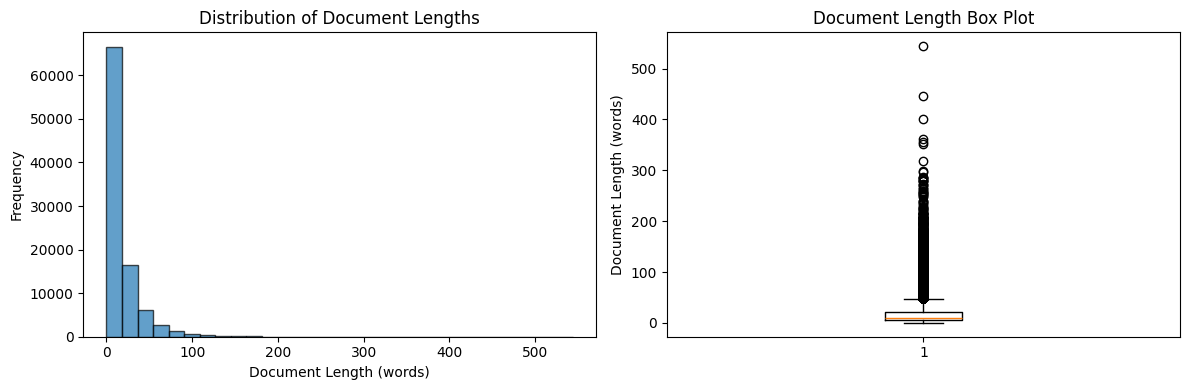

In [48]:
doc_lengths = list(df_par['token_count'])
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.hist(doc_lengths, bins=30, alpha=0.7, edgecolor='black')
plt.xlabel('Document Length (words)')
plt.ylabel('Frequency')
plt.title('Distribution of Document Lengths')

plt.subplot(1, 2, 2)
plt.boxplot(doc_lengths)
plt.ylabel('Document Length (words)')
plt.title('Document Length Box Plot')

plt.tight_layout()
plt.show()

#### Chunk into fixed size

In [3]:
filter_tokens =  ['say', 'have', 'go', 'see', 'do','get','be','come','know','think', 'make', 'good','little','take','look', 'tell']

In [5]:
extension = '.csv'
chunk_size = 400

for file_path in glob.iglob(f'./data/parsed/*.csv'):

    file_name = os.path.basename(file_path)

    df_paragraphs = pd.read_csv(file_path)
    df_paragraphs = df_paragraphs.fillna('')

    file_name = f'./data/chunks/{file_name}'
    with  open(file_name, 'w', newline ='', encoding = 'utf-8') as file:

        header = ['paragraphs', 'tokens']
        writer = csv.DictWriter(file, fieldnames = header)
        writer.writeheader()

        chunk = ""
        paragraphs = ""

        for index, row in df_paragraphs.iterrows():
            if len(row['tokens']) > 0:
                tokens = row['tokens'].split()
                tokens = [token for token in tokens if token not in filter_tokens and token.isalpha() and len(token) > 2]

                chunk += ' '.join(tokens) + ' '
                paragraphs += row['paragraph'].replace("\r", " ") + ' '

                if len(chunk.split()) > chunk_size or index == len(df_paragraphs) - 1:

                    writer.writerow({
                        'paragraphs' : paragraphs,
                        'tokens': chunk
                    })

                    chunk = ""
                    paragraphs = ""

In [6]:
extension = '.csv'
with  open('./data/ChiLit_Chunks.csv', 'w', newline ='', encoding = 'utf-8') as file:

    header = ['book_id', 'chapter_num', 'paragraph_num', 'paragraph_text', 'tokens']
    writer = csv.DictWriter(file, fieldnames = header)
    writer.writeheader()

    for file_path in glob.iglob(f'./data/chunks/*{extension}'):
        file_name = os.path.basename(file_path)
        file_info = file_name.replace(extension, '').split("_")
        book_id = file_info[0]
        chapter_num = int(file_info[1])

        with open(file_path, mode ='r', encoding='utf-8') as file_csv:
            csvFile = csv.reader(file_csv)
            next(csvFile)
            paragraph_num = 0
            for lines in csvFile:

                paragraph_num += 1
                paragraph_text = lines[0]
                tokens = lines[1]

                writer.writerow(
                    {
                        'book_id' : book_id,
                        'chapter_num' : chapter_num,
                        'paragraph_num' : paragraph_num,
                        'paragraph_text' : paragraph_text,
                        'tokens': tokens
                    }
                )

In [7]:
df_chunks = pd.read_csv('./data/ChiLit_Chunks.csv', encoding = 'utf-8')

In [8]:
df_chunks['token_count'] = df_chunks['tokens'].str.split().str.len()
df_chunks['token_count'] = df_chunks['token_count'].fillna(0)

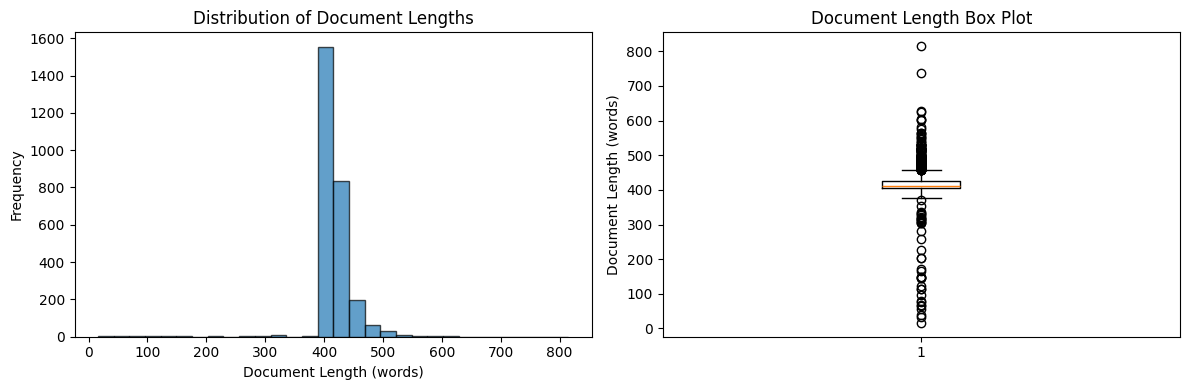

In [9]:
doc_lengths = list(df_chunks['token_count'])
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.hist(doc_lengths, bins=30, alpha=0.7, edgecolor='black')
plt.xlabel('Document Length (words)')
plt.ylabel('Frequency')
plt.title('Distribution of Document Lengths')

plt.subplot(1, 2, 2)
plt.boxplot(doc_lengths)
plt.ylabel('Document Length (words)')
plt.title('Document Length Box Plot')

plt.tight_layout()
plt.show()

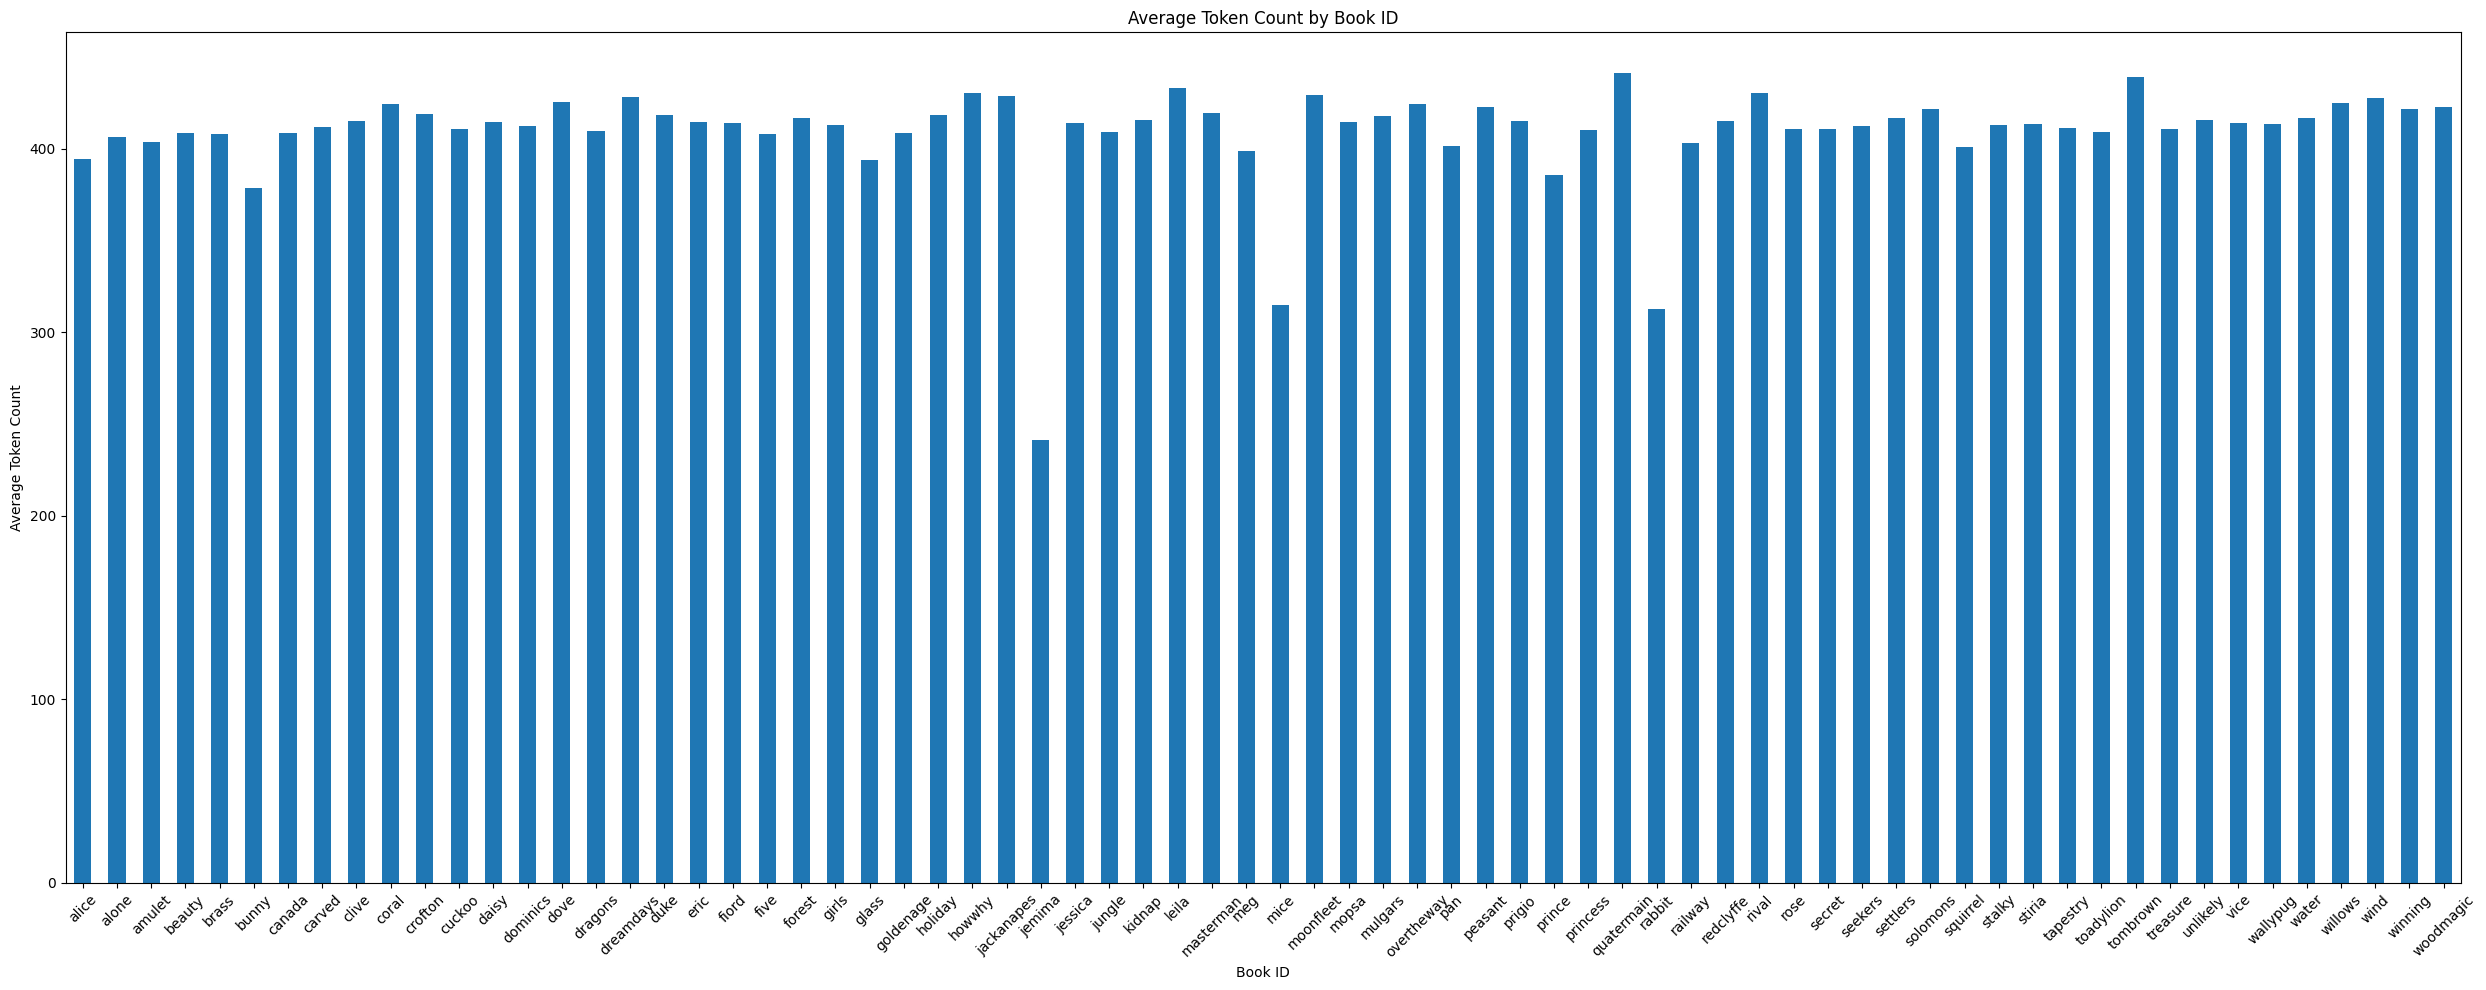

In [10]:
# Group by book_id and compute the mean token count
avg_token_count = df_chunks.groupby(['book_id'])['token_count'].mean()

# Plot
avg_token_count.plot(kind='bar', figsize=(25, 10))
plt.xlabel('Book ID')
plt.ylabel('Average Token Count')
plt.title('Average Token Count by Book ID')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [13]:
sorted(df_chunks.groupby(['book_id'])['token_count'].mean())

[241.5,
 313.0,
 315.0,
 379.0,
 385.8181818181818,
 394.125,
 394.53846153846155,
 398.9230769230769,
 401.0,
 401.74074074074076,
 403.19444444444446,
 404.0,
 406.75,
 407.94594594594594,
 408.0681818181818,
 408.8095238095238,
 408.84,
 408.8666666666667,
 409.07894736842104,
 409.3333333333333,
 410.0357142857143,
 410.24,
 410.6923076923077,
 410.94444444444446,
 411.0,
 411.1190476190476,
 411.7,
 411.9583333333333,
 412.4642857142857,
 412.5625,
 413.275,
 413.3125,
 413.6923076923077,
 413.8,
 414.1,
 414.1666666666667,
 414.43548387096774,
 414.80434782608694,
 414.95652173913044,
 414.96875,
 415.3068181818182,
 415.3933333333333,
 415.4,
 415.82978723404256,
 416.0,
 416.8085106382979,
 416.8285714285714,
 416.94117647058823,
 417.9230769230769,
 418.72,
 418.73214285714283,
 418.9032258064516,
 419.42857142857144,
 421.5846153846154,
 421.90909090909093,
 422.95,
 423.1142857142857,
 424.61538461538464,
 424.7857142857143,
 425.1666666666667,
 425.44303797468353,
 427.5476